# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [9]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 4

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [10]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================

In [11]:
# Split into 70% Training, 30% Validation
train_size = int(0.7 * len(X_full))
X_train, X_val = X_full[:train_size], X_full[train_size:]
y_train, y_val = y_full[:train_size], y_full[train_size:]

In [12]:
# ======================================================================
# PART 2: The Mechanics (Manual MLP Implementation)
# ======================================================================

# Hyperparameters
input_size = 2
hidden_size = 16
output_size = 1
learning_rate = 0.01
epochs = 2000

# Initialize Weights and Biases manually
# Architect: 3 hidden layers (16 neurons each)
def init_weights(shape):
    return (torch.randn(shape) * 0.1).requires_grad_(True)

w1, b1 = init_weights((input_size, hidden_size)), torch.zeros(hidden_size, requires_grad=True)
w2, b2 = init_weights((hidden_size, hidden_size)), torch.zeros(hidden_size, requires_grad=True)
w3, b3 = init_weights((hidden_size, hidden_size)), torch.zeros(hidden_size, requires_grad=True)
w4, b4 = init_weights((hidden_size, output_size)), torch.zeros(output_size, requires_grad=True)

params = [w1, b1, w2, b2, w3, b3, w4, b4]

def forward(X):
    # Layer 1
    z1 = torch.matmul(X, w1) + b1
    a1 = torch.relu(z1)
    # Layer 2
    z2 = torch.matmul(a1, w2) + b2
    a2 = torch.relu(z2)
    # Layer 3
    z3 = torch.matmul(a2, w3) + b3
    a3 = torch.relu(z3)
    # Output Layer
    z4 = torch.matmul(a3, w4) + b4
    return torch.sigmoid(z4)

def compute_loss(y_pred, y_true):
    # Manual Binary Cross Entropy with numerical stability (torch.clamp)
    y_pred = torch.clamp(y_pred, 1e-7, 1 - 1e-7)
    loss = -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    return loss

def compute_accuracy(y_pred, y_true):
    predictions = (y_pred > 0.5).float()
    return (predictions == y_true).float().mean().item()

# Training Loop
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(epochs):
    # Forward Pass
    y_pred = forward(X_train)
    loss = compute_loss(y_pred, y_train)

    # Backward Pass (Autograd allowed)
    loss.backward()

    # Manual Optimization (SGD)
    with torch.no_grad():
        for p in params:
            p -= learning_rate * p.grad
            p.grad.zero_() # Reset gradients

    # Telemetry
    with torch.no_grad():
        val_pred = forward(X_val)
        val_loss = compute_loss(val_pred, y_val)

        train_acc = compute_accuracy(y_pred, y_train)
        val_acc = compute_accuracy(val_pred, y_val)

        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss.item())
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.4f}, Val Acc {val_acc:.4f}")


Epoch 0: Loss 0.6933, Val Acc 0.5156
Epoch 200: Loss 0.6792, Val Acc 0.5956
Epoch 400: Loss 0.6741, Val Acc 0.5956
Epoch 600: Loss 0.6723, Val Acc 0.5956
Epoch 800: Loss 0.6716, Val Acc 0.5956
Epoch 1000: Loss 0.6713, Val Acc 0.5956
Epoch 1200: Loss 0.6711, Val Acc 0.5956
Epoch 1400: Loss 0.6710, Val Acc 0.5956
Epoch 1600: Loss 0.6709, Val Acc 0.5956
Epoch 1800: Loss 0.6707, Val Acc 0.5956


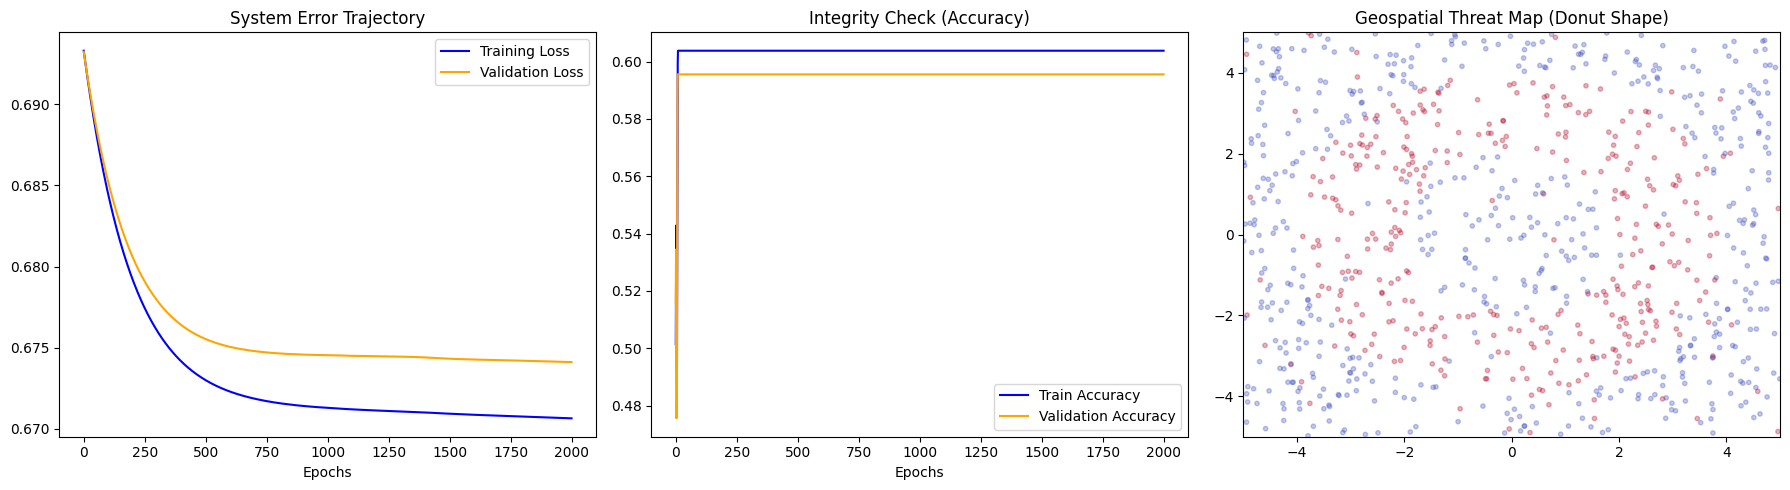

In [13]:
# ======================================================================
# PART 3: The GDC Dashboard (Required Output)
# ======================================================================
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# 1. System Error Trajectory (Loss Plot)
ax[0].plot(history['train_loss'], label='Training Loss', color='blue')
ax[0].plot(history['val_loss'], label='Validation Loss', color='orange')
ax[0].set_title("System Error Trajectory")
ax[0].set_xlabel("Epochs")
ax[0].legend()

# 2. Integrity Check (Accuracy Plot)
ax[1].plot(history['train_acc'], label='Train Accuracy', color='blue')
ax[1].plot(history['val_acc'], label='Validation Accuracy', color='orange')
ax[1].set_title("Integrity Check (Accuracy)")
ax[1].set_xlabel("Epochs")
ax[1].legend()

# 3. Geospatial Threat Map (Decision Boundary)
x_min, x_max = -5, 5
y_min, y_max = -5, 5
xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100), torch.linspace(y_min, y_max, 100), indexing='ij')
grid_points = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=1)

with torch.no_grad():
    Z = forward(grid_points).reshape(xx.shape)

# Plot validation data points
ax[2].scatter(X_val[:, 0], X_val[:, 1], c=y_val.flatten(), cmap='coolwarm', alpha=0.3, s=10)
# Overlay Decision Boundary (Confidence = 0.5)
ax[2].contour(xx.numpy(), yy.numpy(), Z.numpy(), levels=[0.5], colors='black', linewidths=2)
ax[2].set_title("Geospatial Threat Map (Donut Shape)")

plt.tight_layout()
plt.show()